<!--NOTEBOOK_HEADER-->
*This notebook contains material from [PyRosetta](https://RosettaCommons.github.io/PyRosetta.notebooks);
content is available [on Github](https://github.com/RosettaCommons/PyRosetta.notebooks.git).*

# Protein folding
Keywords: pose_from_sequence(), random move, scoring move, Metropolis, assign(), Pose()

Any folding algorithm requires…


- …a search strategy, an algorithm to generate many candidate structures (or decoys) and…


- …a scoring function to discriminate near-native structures from all the others.


In this workshop you will write your own Monte Carlo protein folding algorithm from scratch, and we will explore a couple of the tricks used by Simons et al. (1997, 1999) to speed up the folding search.


### Suggested Reading
1. A. V. Finkelstein _et al._, "Protein folding problem: enigma, paradox, solution," **Biophys. Rev.** 14, 1255-1272 (2022).

### Other Suggested Readings
2. K. T. Simons _et al._, “Assembly of Protein Structures from Fragments,” **J. Mol. Biol.**
268, 209-225 (1997).
3. K. T. Simons _et al._, “Improved recognition of protein structures,” **Proteins** 34, 82-95
(1999).
4. Chapter 4 (Monte Carlo methods) of M. P. Allen & D. J. Tildesley, **Computer Simulation of Liquids**, Oxford University Press, 1989.

## Setup

In [ ]:
!pip install py3Dmol
import py3Dmol

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Basic folding algorithm

### Building the pose
In this workshop, you will be folding a 10 residue protein by building a simple de novo folding algorithm. Start by initializing PyRosetta as usual.

Create a simple poly-alanine `pose` with 10 residues for testing your folding algorithm. Store the pose in a variable called "polyA."

In [ ]:
!pip install pyrosettacolabsetup
import pyrosettacolabsetup; pyrosettacolabsetup.install_pyrosetta()
import pyrosetta; pyrosetta.init()
from pyrosetta import *


In [ ]:
polyA = pyrosetta.pose_from_sequence('A' * 10)

polyA.pdb_info().name("polyA")

__Question:__
Check the backbone dihedrals of a few residues (except the first and last) using the `.phi()` and `.psi()` methods in `Pose`. What are the values of $\phi$ and $\psi$ dihedrals? You should see ideal bond lengths and angles, but the dihedrals may not be as realistic.

In [ ]:
print("phi: %i" %polyA.phi(9))
print("psi: %i" %polyA.psi(9))

We can visualise the pose with Py3Dmol. PyMOL is another great visualisation option; however, it requires a local installation.

Py3Dmol provides a wide range of visualisation options to render molecular structures within Jupyter and Colab notebooks. Check out [Py3dmol GitHub](https://github.com/3dmol/3Dmol.js) for full documentation and options available for customisation.


In [ ]:

import tempfile


# Function to display the static pose
def display_protein(pdb_string):
    viewer = py3Dmol.view(width=800, height=600)
    viewer.addModel(pdb_string, 'pdb')
    # viewer.setStyle({'cartoon': {'color': 'spectrum'}})
    viewer.setStyle({'stick': {'colorscheme': 'greenCarbon'}})
    viewer.zoomTo()
    viewer.show()

# Save the pose to a temporary PDB file and read it as a string
with tempfile.NamedTemporaryFile(suffix='.pdb') as tmp:
    polyA.dump_pdb(tmp.name)
    with open(tmp.name, 'r') as pdb_file:
        pdb_string = pdb_file.read()

# Display the PDB string using Py3Dmol
display_protein(pdb_string)

### Building A Basic *de Novo* Folding Algorithm

Now, write a program that implements a Monte Carlo algorithm to optimize the protein conformation. You can do this here in the notebook, or you may use a code editor to write a `.py` file and execute in a Python or iPython shell.  

Our main program will include 100 iterations of making a random trial move, scoring the protein, and accepting/rejecting the move. Therefore, we can break this algorithm down into three smaller subroutines: **random, score, and decision.**

#### Step 1: Random Move

For the **random** trial move, write a subroutine to choose one residue at random using `random.randint()` and then randomly perturb either the φ or ψ angles by a random number chosen from a Gaussian distribution. Use the Python built-in function `random.gauss()` from the `random` library with a mean of the current angle and a standard deviation of 25°. After changing the torsion angle, visualise the new pose.

Hint: Ask GPT-4

``` python
import random
import math

def perturb_angle(angles):
    # Choose a random residue
    residue_index = random.randint(0, len(angles) - 1)
    
    # Choose whether to perturb φ or ψ angle
    angle_choice = random.choice(['φ', 'ψ'])
    
    # Get the current angle
    current_angle = angles[residue_index][angle_choice]
    
    # Calculate the perturbed angle using a Gaussian distribution
    mean = current_angle
    stddev = 25
    perturbed_angle = random.gauss(mean, stddev)
    
    # Update the angle in the angles list
    angles[residue_index][angle_choice] = perturbed_angle
    
    return angle`

```

In [ ]:
import math
import random

def randTrial(your_pose):
    randNum = random.randint(2, your_pose.total_residue())
    currPhi = your_pose.phi(randNum)
    currPsi = your_pose.psi(randNum)
    newPhi = random.gauss(currPhi, 25)
    newPsi = random.gauss(currPsi, 25)
    your_pose.set_phi(randNum,newPhi)
    your_pose.set_psi(randNum,newPsi)
    return your_pose

#### Step 2: Scoring Move

For the **scoring** step, we need to create a scoring function and make a subroutine that simply returns the numerical energy score of the pose.

In [ ]:
sfxn = get_fa_scorefxn()

def score(your_pose):
    return sfxn(your_pose)

#### Step 3: Accepting/Rejecting Move
For the **decision** step, we need to make a subroutine that either accepts or rejects the new conformatuon based on the Metropolis criterion. The Metropolis criterion has a probability of accepting a move as $P = \exp( -\Delta G / kT )$. When $ΔE ≥ 0$, the Metropolis criterion probability of accepting the move is $P = \exp( -\Delta G / kT )$. When $ΔE < 0$, the Metropolis criterion probability of accepting the move is $P = 1$. Use $kT = 1$ Rosetta Energy Unit (REU).

In [ ]:
def decision(before_pose, after_pose):
    E = score(after_pose) - score(before_pose)
    if E < 0:
        return after_pose
    elif random.uniform(0, 1) >= math.exp(-E/1):
        return before_pose
    else:
        return after_pose

##### Understanding the Metropolis criterion

**Chat-GPT prompt:**

Explain to me why this code:
```python
def decision(before_pose, after_pose):
    E = score(after_pose) - score(before_pose)
    if E < 0:
        return after_pose
    elif random.uniform(0, 1) >= math.exp(-E/1):
        return before_pose
    else:
        return after_pose
```
accepts the new after pose when $ΔE ≥ 0$ with a probability of $P = \exp( -\Delta G / kT )$.

**Chat-GPT response:**
This function you provided seems to implement the **Metropolis criterion**, which is widely used in Monte Carlo methods to decide whether to accept a new state based on an energy difference (ΔE) between two states. Let's break down the logic step by step:

##### **1. Energy Difference Calculation**:
```python
E = score(after_pose) - score(before_pose)
```
- Here, $E$ represents the energy difference $\Delta E = E_{\text{after}} - E_{\text{before}}$.
- If $E < 0$ , then the new conformation `after_pose` has lower energy than the previous one `before_pose`, and it is energetically favorable.

##### **2. Acceptance Criterion**:
The code has two main conditions that affect whether the new pose is accepted:

##### Case 1: $\Delta E < 0$
```python
if E < 0:
    return after_pose
```
- If $E < 0$ (i.e., $E_{\text{after}} < E_{\text{before}}$), the new pose is automatically accepted because it's a lower energy state, and we return `after_pose`.

##### Case 2: $\Delta E \geq 0$
If $E \geq 0$, the energy has either remained the same or increased, so accepting this new pose is not energetically favorable. However, the Metropolis criterion allows the new state to be accepted with some probability. This is where this part of the code comes in:
```python
elif random.uniform(0, 1) >= math.exp(-E/1):
    return before_pose
else:
    return after_pose
```
Let’s break this down:

- **$\mathbb{P}(\text{accept}) = \exp\left( -\frac{\Delta E}{kT} \right)$**

  In the Metropolis algorithm, when the energy difference is positive, the probability of accepting the new state is $P = \exp(-\Delta E / kT)$, where:
  - $\Delta E$ is the energy difference.
  - $k$ is the Boltzmann constant (often set to 1 in computational simulations).
  - $T$ is the temperature.
  
- **$kT = 1$** in this case:
  - In your function, it seems $kT$ has been set to 1, so the probability simplifies to $P = \exp(-E/1)$, which matches the expression in the code.

- **The `random.uniform(0, 1)` Check**:
  - `random.uniform(0, 1)` generates a random number between 0 and 1.
  - If this random number is **greater than or equal** to $\exp(-E)$, the move is **rejected** and the function returns `before_pose`.
  - Otherwise, the move is **accepted** and the function returns `after_pose`.

See below how $P$ goes to 0 when $E$ becomes large:

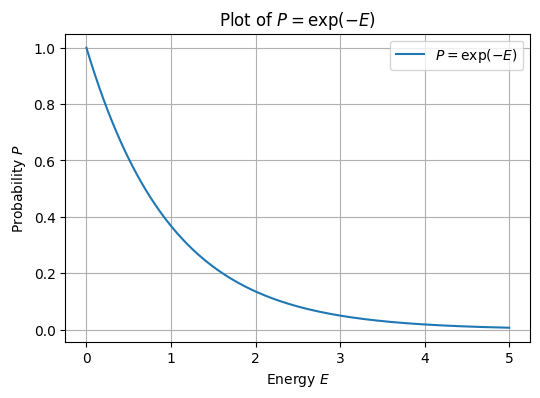

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Define the energy range
E_values = np.linspace(0, 5, 400)

# Calculate the acceptance probability P = exp(-E)
P_values = np.exp(-E_values)

# Plotting the probability function
plt.figure(figsize=(6, 4))
plt.plot(E_values, P_values, label=r'$P = \exp(-E)$')
plt.title(r'Plot of $P = \exp(-E)$')
plt.xlabel(r'Energy $E$')
plt.ylabel(r'Probability $P$')
plt.grid(True)
plt.legend()
plt.show()


AI assistants can help you understand the code and write better code.

**Prompt:**
is this a good implementation of the Metropolis criterion? Can you make it more efficient?


**Chat-GPT:** Your current implementation of the Metropolis criterion is correct but could be made more efficient. Let's first analyze why and then discuss improvements.

#### Current Implementation:
```python
def decision(before_pose, after_pose):
    E = score(after_pose) - score(before_pose)
    if E < 0:
        return after_pose
    elif random.uniform(0, 1) >= math.exp(-E/1):
        return before_pose
    else:
        return after_pose
```

This implementation is correct, but there are some inefficiencies:

- **Redundant energy calculation**: The energy difference $ \Delta E = E_{\text{after}} - E_{\text{before}} $ is calculated multiple times.
- **Unnecessary operations**: The division by 1 in $ \text{exp}(-E/1) $ can be avoided.
- **Costly random number generation**: You could make the random number comparison more efficient.

##### Optimized Code:

```python
import random
import math

def decision(before_pose, after_pose):
    E_before = score(before_pose)
    E_after = score(after_pose)
    delta_E = E_after - E_before

    if delta_E < 0:
        return after_pose
    else:
        # Generate a random number and directly compare with exp(-delta_E)
        if random.uniform(0, 1) < math.exp(-delta_E):
            return after_pose
        else:
            return before_pose
```

##### Key Improvements:
1. **Single energy calculation**: We store the energy values for $ E_{\text{before}} $ and $ E_{\text{after}} $, which reduces the number of times the `score()` function is called.
   
2. **Simplified logic**: Instead of using `random.uniform(0, 1) >= \exp(-E)`, we directly compare the random number with $ \exp(-\Delta E) $, making the logic more efficient.

This should make your code more efficient, especially when the `score()` function is computationally expensive.




#### Step 4: Visualisation
Visualise the trajectory of the poly-alanine peptide as it folds over time. The `animate_folding` function collects a series of poses as the poly-alanine folds. Py3dmol then animates through the frames, showing the gradual folding.

In [ ]:
def visualize_multimodel_pdb(pdb_file):
    """Visualizes a multi-model PDB file with Py3dmol."""

    # Read the multi-model PDB file
    with open(pdb_file, 'r') as file:
        pdb_content = file.read()

    # Create the viewer
    viewer = py3Dmol.view(width=800, height=600)

    # Add the PDB content as a model
    viewer.addModelsAsFrames(pdb_content, 'pdb')  # Load all frames

    # Set the cartoon representation for the models
    viewer.setStyle({'cartoon': {'color': 'spectrum'}})

    # Zoom and fit the structure to the viewer
    viewer.zoomTo()

    # Animate through the frames
    viewer.animate({'loop': 'forward', 'interval': 2000})  # 2000 ms per frame

    # Show the viewer
    viewer.show()



#### Step 5: Execution
Now we can put these three subroutines together in our main program! Write a loop in the main program so that it performs 100 iterations of: making a random trial move, scoring the protein, and accepting/rejecting the move.

After each iteration of the search, output the current pose energy and the lowest energy ever observed. **The final output of this program should be the lowest energy conformation that is achieved at *any* point during the simulation.** Be sure to use `low_pose.assign(pose)` rather than `low_pose = pose`, since the latter will only copy a pointer to the original pose.

In [ ]:
import pyrosetta
from pyrosetta import Pose

def basic_folding(your_pose, steps, framesfile, outputfile):
    """Basic folding algorithm that completes 1000 Monte-Carlo iterations on a given pose"""

    lowest_pose = Pose()  # Create an empty pose for tracking the lowest energy pose
    folding_poses = []  # Create an empty list to store the poses for animation

    with open(framesfile, 'w') as frames:  # Open framesfile for writing multiple models
        for i in range(steps):
            if i == 0:
                lowest_pose.assign(your_pose)

            before_pose = Pose()
            before_pose.assign(your_pose)  # Keep track of pose before random move

            after_pose = Pose()
            after_pose.assign(randTrial(your_pose))  # Do random move and store the pose

            your_pose.assign(decision(before_pose, after_pose))  # Keep the new pose or old pose

            if score(your_pose) < score(lowest_pose):  # Updating lowest pose
                lowest_pose.assign(your_pose)

            if i % 100 == 0:  # Save every 100th pose
                # Use a temporary file to dump the pose to string
                with open('temp_frame.pdb', 'w') as temp_pdb:
                    your_pose.dump_pdb(temp_pdb.name)  # Dump PDB to a temp file

                # Now read the temp file content and append it as a new model
                with open('temp_frame.pdb', 'r') as temp_pdb:
                    frames.write(f"MODEL {i}\n")
                    frames.write(temp_pdb.read())  # Write PDB content from temp file
                    frames.write("ENDMDL\n")  # End this model

                print(f"Iteration # {i}")  # Output
                print(f"Current pose score: {score(your_pose):1.3f}")  # Output current score
                print(f"Lowest pose score: {score(lowest_pose):1.3f}")  # Output lowest score

    # Save the lowest energy pose as a separate PDB file
    your_pose.dump_pdb(outputfile)

    return lowest_pose


In [ ]:
basic_folding(polyA, 50000, "polyA-frames.pdb", "polyA-freefold.pdb")

In [ ]:
with open('polyA-freefold.pdb', 'r') as file:
    pdb_content = file.read()

display_protein(pdb_content)

In [ ]:
visualize_multimodel_pdb('polyA-frames.pdb')

### Exercise 1: Comparing to Alpha Helices
Write a new program that nudges the $A_{10}$ sequence to fold into an ideal α-helix. Compare the final poses (the one from your previous program and the new "nudged" into α-helix in PyMOL and their scores.  Is your initial program working? Has it converged to a good solution?

In [ ]:
# Your code here


### The Monte Carlo algorithm

The Monte Carlo algorithm in PyRosetta is widely used for sampling conformational space and optimizing protein structures. It is often used in the context of protein folding, refinement, and design. Here’s a high-level description of how the Monte Carlo (MC) algorithm works in PyRosetta:

1. **Initial Pose**: The Monte Carlo algorithm starts with an initial pose, which is the structure of the protein you're trying to optimize. This initial pose can be a folded, partially folded, or even a completely random structure.

2. **Perturbation**: The core of the Monte Carlo algorithm involves generating random changes or perturbations to the structure. In the case of protein folding, this usually means randomly altering the **phi** and **psi** torsion angles of residues (as you are doing). These random perturbations create a "trial move" to explore new conformations.

3. **Energy Calculation**: After each perturbation, PyRosetta calculates the **energy** of the newly generated conformation using a **scoring function**. The energy represents the stability or likelihood of that structure in terms of physical and chemical interactions (e.g., Van der Waals forces, electrostatic interactions, etc.).

4. **Metropolis Criterion**: The Monte Carlo algorithm uses the **Metropolis criterion** to decide whether to accept or reject the new conformation. The Metropolis criterion is based on comparing the energy of the new conformation to the previous one:
   - If the new conformation has a lower energy than the previous one (i.e., more favorable), it is **accepted**.
   - If the new conformation has a higher energy, it can still be accepted with a probability proportional to the difference in energy and a temperature parameter. This allows the algorithm to occasionally accept higher-energy conformations to escape local minima in the energy landscape.

   The Metropolis acceptance probability is given by:
   $
   P(\text{accept}) = e^{-\Delta E / k_B T}
   $
   where $\Delta E$ is the difference in energy between the new and old conformations, $k_B$ is Boltzmann's constant, and $T$ is the temperature.

5. **Iterations**: This process of random perturbation and acceptance/rejection is repeated over many iterations to explore the conformational space.

6. **Convergence**: The algorithm runs for a predefined number of iterations or until a convergence criterion is met. The lowest-energy conformation encountered during the Monte Carlo simulation is often retained as the **final folded structure**.


This script implements the Monte Carlo algorithm to fold the polyA peptide. It takes ca. 10 minutes to run in a laptop

```python
# import rosetta libraries and initialise
from pyrosetta import *
from pyrosetta.rosetta import *
from pyrosetta.teaching import *
init()


p = pose_from_pdb("mc_initial.pdb")

# set up scrore function
scorefxn = get_score_function(True)

#scorefxn.set_weight(hbond_lr_bb, 1.0)
#scorefxn.set_weight(vdw, 1.0)


# set uo simulation parameters. The MonteCarlo object is initialized with a score function to calculate the energy, a pose object to serve as a reference structure, and the temperature, which is used in the Metropolis Criterion.
# Within this function, the energy of inputted pose is calculated using the score function and compared to the energy of the last accepted pose object. The Metropolis criterion is applied to the pose; if the move was accepted than the inputted pose remains unchanged, and the last accepted pose, within the MonteCarlo object, is updated. If the move was rejected, the inputted pose is switched to the last accepted pose, and the last accepted pose is unchanged.

ncycles = 5000000
kT = 1.0
mc = MonteCarlo(p, scorefxn, kT)

# set up conformational search space
movemap = MoveMap()
movemap.set_bb(True)

#set up movers
small_mover = SmallMover(movemap, kT, 5)

# run simulation
for i in range(1, ncycles):
	small_mover.apply(p)
	mc.boltzmann(p)

#output lowest energy structure. The lowest energy structure assessed by the MonteCarlo object can be accessed as well. The lowest energy structure is not only recovered at the end of the simulation, but often intermittently throughout the simulation as well.
mc.recover_low(p)
dump_pdb(p, "mc_final.pdb")
```

In [ ]:
# import rosetta libraries and initialise
from pyrosetta import *
from pyrosetta.rosetta import *
init()


p = pose_from_pdb("/content/google_drive/MyDrive/BIP_24-25/protein_folding/mc_initial.pdb")

# set up scrore function
scorefxn = get_fa_scorefxn()

#scorefxn.set_weight(hbond_lr_bb, 1.0)
#scorefxn.set_weight(vdw, 1.0)


# set up simulation parameters. The MonteCarlo object is initialized with a
# score function to calculate the energy, a pose object to serve as a reference
# structure, and the temperature, which is used in the Metropolis Criterion.
# Within this function, the energy of inputted pose is calculated using the
# score function and compared to the energy of the last accepted pose object.
# The Metropolis criterion is applied to the pose; if the move was accepted than
# the inputted pose remains unchanged, and the last accepted pose, within the
# MonteCarlo object, is updated. If the move was rejected, the inputted pose is
# switched to the last accepted pose, and the last accepted pose is unchanged.

ncycles = 500000
kT = 1.0
mc = MonteCarlo(p, scorefxn, kT)

# set up conformational search space
movemap = MoveMap()
movemap.set_bb(True)

#set up movers
small_mover = SmallMover(movemap, kT, 5)

# run simulation
for i in range(1, ncycles):
    small_mover.apply(p)
    mc.boltzmann(p)

#output lowest energy structure. The lowest energy structure assessed by the MonteCarlo object can be accessed as well. The lowest energy structure is not only recovered at the end of the simulation, but often intermittently throughout the simulation as well.
mc.recover_low(p)
dump_pdb(p, "mc_final.pdb")

In [ ]:
with open('/content/mc_final.pdb', 'r') as file:
    pdb_content = file.read()

display_protein(pdb_content)